## Import Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, InputSpec
from keras.utils import *
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from scipy.sparse import lil_matrix

## Read Data

In [58]:
data = pd.read_csv('heart_disease_data.csv')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [59]:
data = data.drop_duplicates(ignore_index=True)
data = data.dropna()
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  num       297 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 34.8 KB


In [61]:
data.iloc[:, -1].unique()

array([0, 2, 1, 3, 4], dtype=int64)

## Data Visualization

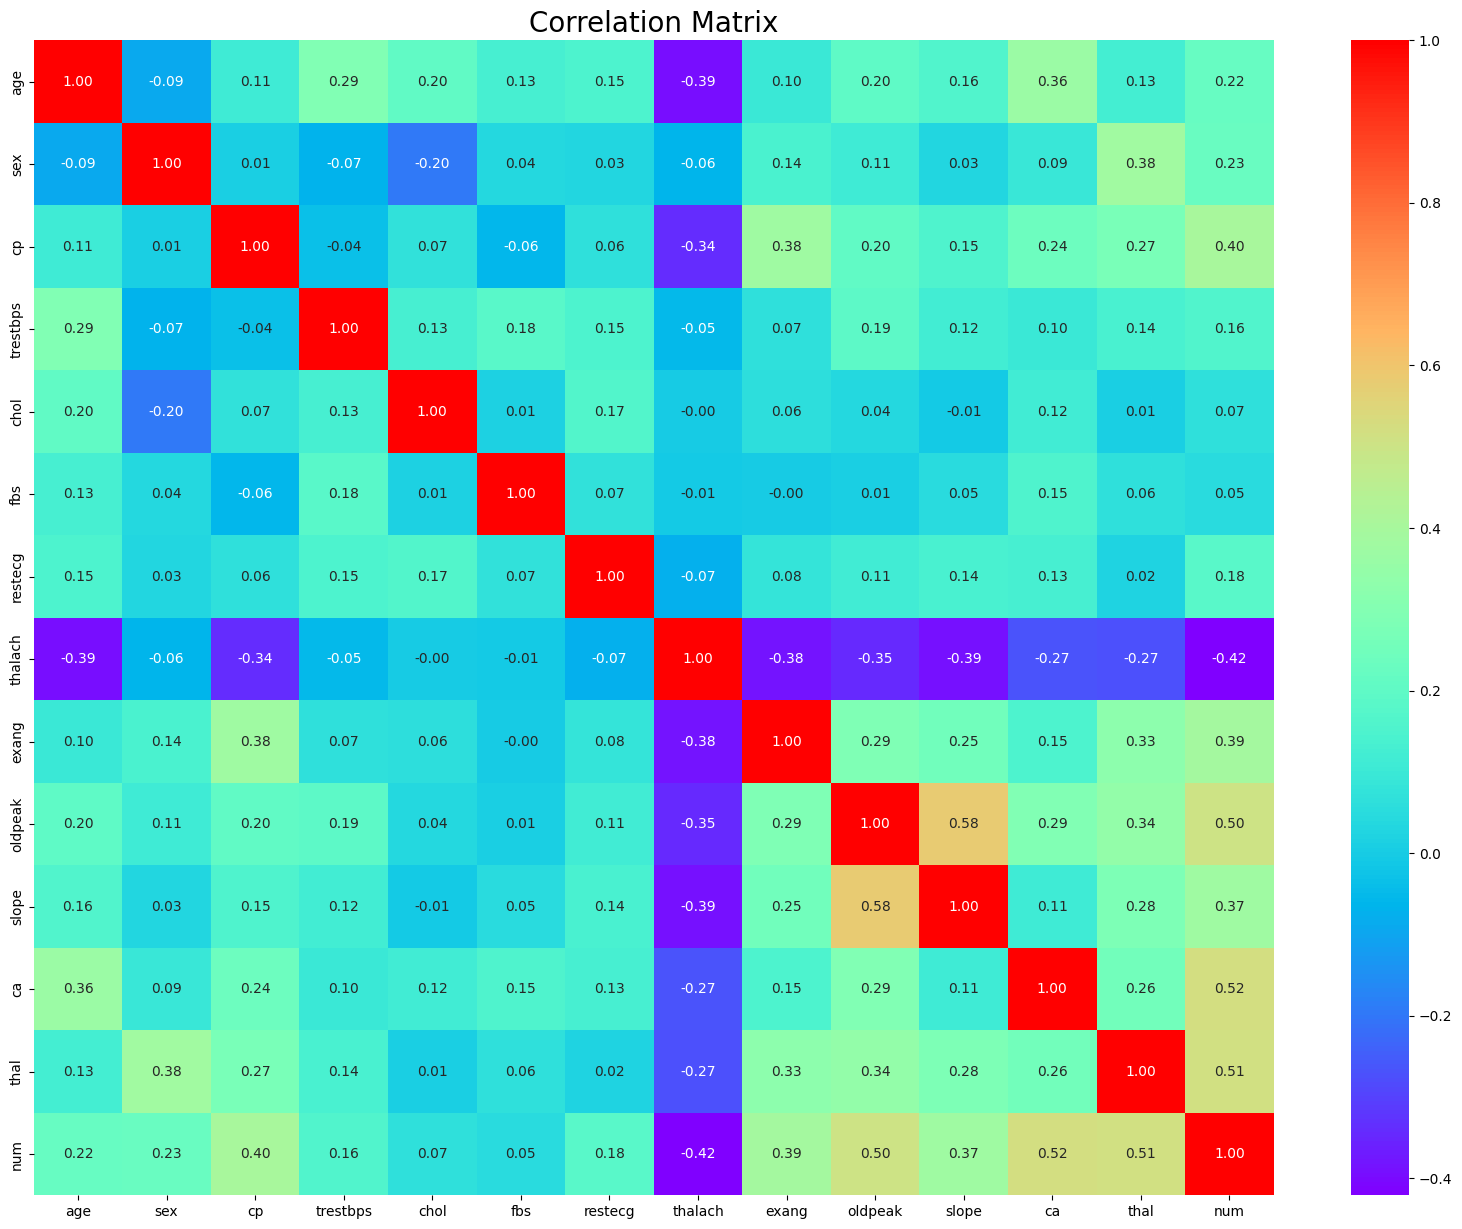

In [62]:
f, ax = plt.subplots(figsize= [20,15])
corr = data.corr()
sns.heatmap(data.corr(), annot=True, fmt=".2f", ax=ax, cmap = "rainbow" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

## Data Preprocessing

In [67]:
scaler = StandardScaler()
scaler.fit(data)

# Transform the DataFrame to obtain the normalized data
data_normalized = scaler.transform(data)

In [68]:
X = data_normalized[:, :-1]
y = data_normalized[:, -1]

In [69]:
X.shape[-1]

13

In [70]:
num_class = len(data.iloc[:, -1].unique())

## Modelling

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [89]:
def DNNModel(in_dim, out_dim):
    model = Sequential([
        tf.keras.layers.Input(shape=in_dim),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(out_dim, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

## Cross Validation

In [90]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [91]:
fold_test = []
fold_pred = []

In [92]:
from sklearn.metrics import accuracy_score
from torchmetrics.functional.classification import multiclass_accuracy, multiclass_auroc, multiclass_f1_score, multiclass_precision, multiclass_recall
import torchmetrics
from sklearn.model_selection import train_test_split

In [93]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
y_test

array([-0.76766788,  0.04371063, -0.76766788,  0.04371063, -0.76766788,
       -0.76766788, -0.76766788, -0.76766788,  0.04371063, -0.76766788,
        0.04371063, -0.76766788, -0.76766788, -0.76766788, -0.76766788,
       -0.76766788, -0.76766788, -0.76766788,  0.85508913, -0.76766788,
        1.66646763,  2.47784613,  0.85508913, -0.76766788,  1.66646763,
       -0.76766788,  0.04371063,  0.04371063, -0.76766788, -0.76766788,
       -0.76766788, -0.76766788,  2.47784613, -0.76766788, -0.76766788,
       -0.76766788,  1.66646763, -0.76766788,  1.66646763,  0.04371063,
       -0.76766788,  1.66646763,  0.85508913, -0.76766788, -0.76766788,
        2.47784613, -0.76766788,  0.85508913, -0.76766788, -0.76766788,
       -0.76766788,  0.85508913,  0.04371063, -0.76766788,  1.66646763,
        0.04371063, -0.76766788, -0.76766788,  1.66646763, -0.76766788])

In [95]:
model = DNNModel(X.shape[-1], 1)

In [96]:
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 0.3932 - accuracy: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 0.3102 - accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2271 - accuracy: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 0.1412 - accuracy: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0526 - accuracy: 0.0000e+00
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: -0.0457 - accuracy: 0.0000e+00
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: -0.1446 - accuracy: 0.0000e+00
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: -0.2528 - accuracy: 0.0000e+00
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: -0.3676 - accuracy: 0.0000e+00
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: -0.4938 - accur

In [38]:
prediction = model.predict(x_test)

2/2 [==============================] - 0s 2ms/step


In [40]:
prediction

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [39]:
accuracy_score(y_test, prediction)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [23]:
for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    x_train, x_test, y_train, y_test = (X[train_idx]), (X[test_idx]), (y[train_idx]), (y[test_idx])
    classifier = DNNModel(x_train.shape[-1], 1)
    
    train_init = time.time()
    classifier.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    train_time = time.time() - train_init

    test_init = time.time()
    prediction = classifier.predict(x_test)
    test_time = time.time() - test_init
    print(prediction)

    fold_test.append(y_test)
    fold_pred.append(prediction)

    preds = torch.tensor(prediction.flatten())
    trues = torch.tensor(y_test)

    print(f"Fold: {fold+1} | Accuracy: {multiclass_accuracy(preds=preds, target=trues, num_classes=num_class).item():.5f} | Train Time: {train_time} | Test Time: {test_time}")  

1/1 [==============================] - 0s 36ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Fold: 1 | Accuracy: 0.50000 | Train Time: 2.463113307952881 | Test Time: 0.06086087226867676
1/1 [==============================] - 0s 36ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Fold: 2 | Accuracy: 0.50000 | Train Time: 2.2745766639709473 | Test Time: 0.05859088897705078
1/1 [==============================] - 0s 38ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Fold: 3 | Accuracy: 1.00000 | Train Time: 2.201225757598877 | Test Time: 0.06128334999084473
1/1 [================

In [ ]:
fold_pred[0]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
accuracy = []
precision = []
recall = []
f1_score = []
auroc = []

for i in range(10):
    trues = torch.tensor(fold_test[i])
    preds = torch.tensor(fold_pred[i].flatten())
    accuracy.append(multiclass_accuracy(preds=preds, target=trues, num_classes=num_class).item())
    precision.append(multiclass_precision(preds=preds, target=trues, num_classes=num_class).item())
    recall.append(multiclass_recall(preds=preds, target=trues, num_classes=num_class).item())
    f1_score.append(multiclass_f1_score(preds=preds, target=trues, num_classes=num_class).item())
    auroc.append(multiclass_auroc(preds.float(), trues.long()).item(), num_class)

print(f"Accuracy: {np.mean(accuracy):.5f} | Precision: {np.mean(precision):.5f} | Recall: {np.mean(recall):.5f} | F1 Score: {np.mean(f1_score):.5f} | AUC ROC: {np.mean(auroc):.5f}")

TypeError: multiclass_auroc() missing 1 required positional argument: 'num_classes'